In [2]:
import keras.metrics
import mne
import os
import os.path as osp
from tqdm import tqdm

import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pyriemann.spatialfilters import Xdawn
import numpy as np
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import XdawnCovariances
from pyriemann.estimation import Covariances

from braindecode.datasets import create_from_X_y
from braindecode import EEGClassifier
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from braindecode.datasets import create_from_mne_epochs

from braindecode import EEGRegressor
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets import BaseDataset, BaseConcatDataset
from braindecode.training.losses import CroppedLoss
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.util import set_random_seeds, create_mne_dummy_raw

import numpy as np
import pandas as pd
import torch
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split

from braindecode import EEGRegressor
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets import BaseDataset, BaseConcatDataset
from braindecode.training.losses import CroppedLoss
from braindecode.models import Deep4Net
from braindecode.models import ShallowFBCSPNet
from braindecode.models.util import to_dense_prediction_model, get_output_shape
from braindecode.util import set_random_seeds, create_mne_dummy_raw
import winsound


from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
from tensorflow.keras.utils import set_random_seed
from tensorflow import one_hot
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

#from EEGModels import EEGNet, ShallowConvNet, DeepConvNet
from numpy.random import seed
from tensorflow.keras.utils import set_random_seed


import time

In [33]:
mne.set_log_level(verbose="Warning") # set all the mne verbose to warning

seed(2002012)
set_random_seed(2002012)

In [4]:
# #init_path = "\\\\bor-nas1.bordeaux.inria.fr\\potiocdata\BCI\\2022 BCI OPEN DATA\\BCI Database - Copie\\Signals"
# init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
# files_dir=os.listdir(init_path)[:3]
# participant_dir= [os.listdir(osp.join(init_path,files_dir[i])) for i in range(len(files_dir))]
# print("you have succesfuly acces to the directory : ",init_path)
#


In [5]:
# participant_dir[0].remove("A40")

In [6]:
# def collect_data(files_dir, participant_dir):
#     dic_data_train ={}
#     dic_data_test ={}
#     for i in range(len(files_dir)):
#         for j in range(len(participant_dir[i])):
#             #Train dataset
#             dic_data_train[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
#             dic_data_train[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")
#
#             #Test dataset
#             dic_data_test[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
#             dic_data_test[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
#             try : # allow to manage the one where there is no _5 and _6 files
#                 dic_data_test[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
#             except FileNotFoundError:
#                 pass
#
#             try :
#                 dic_data_test[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
#             except FileNotFoundError:
#                 pass
#     return dic_data_train, dic_data_test

def collect_data(files_dir, participant_dir):
    dic_data={}

    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data[participant_dir[i][j]+"_1"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R1_acquisition.gdf"), verbose="CRITICAL")
            dic_data[participant_dir[i][j]+"_2"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R2_acquisition.gdf"), verbose="CRITICAL")

            #Test dataset
            dic_data[participant_dir[i][j]+"_3"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R3_onlineT.gdf"), verbose="CRITICAL")
            dic_data[participant_dir[i][j]+"_4"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R4_onlineT.gdf"), verbose="CRITICAL")
            try : # allow to manage the one where there is no _5 and _6 files
                dic_data[participant_dir[i][j]+"_5"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R5_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try :
                dic_data[participant_dir[i][j]+"_6"]= mne.io.read_raw_gdf(osp.join(init_path,files_dir[i],participant_dir[i][j],participant_dir[i][j]+"_R6_onlineT.gdf"), verbose="CRITICAL")
            except FileNotFoundError:
                pass
    return dic_data

In [7]:
# print("START extraction data")
# dic_data =  collect_data(files_dir, participant_dir)
# print("extraction data DONE")

In [8]:
# train_dataset = np.array(pd.read_csv(init_path+"\\trainkey.csv", index_col=0).index)
# valid_dataset = np.array(pd.read_csv(init_path+"\\validkey.csv", index_col=0).index)

In [9]:
def create_key(df , train = 1 , test = 1 ):

    keys = np.array([])

    for  val  in df :
        if train :
            keys = np.append(keys, [val+"_1" ,val+"_2"])
        if test :
            if val == "A59":
                keys = np.append(keys, [val+"_3" ,val+"_4"])
            else :
                keys = np.append(keys, [val+"_3" ,val+"_4",  val+"_5", val+"_6"])

    return keys

In [10]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1], verbose= None)


    return raw



In [11]:
# def epoching(dict, key_session =[], steps_preprocess = None , key_events={"769":0 ,"770":1}) :
#     """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
#      Return the epochs list as X and tje label as Y"""
#
#     #---------------------------------------------
#     tmin= steps_preprocess["tmin"]
#     tmax = steps_preprocess["tmax"]
#     length_epoch = steps_preprocess["lenght"]
#     overlap = steps_preprocess["overlap"]
#     #---------------------------------------------
#
#     list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
#     list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)
#
#     #n_chans = len(dict[key_session[0]].ch_names) - len(steps_preprocess["drop_channels"])
#     n_chans = 27 # must be changed if we drop more channels
#     time_step = int(length_epoch  * dict[key_session[0]].info['sfreq'])
#     n_events = len(list_start)* 40 * len(key_session) # 40 represent the number of events in each raw data
#
#     X= torch.zeros((n_events, n_chans, time_step))
#     Y= torch.zeros((n_events))
#
#     i = 0
#
#     for key in tqdm(key_session , desc="epoching"):
#
#
#         if steps_preprocess is not None :
#             _ =  preprocess(dict[key],steps_preprocess)
#
#         epoch= mne.Epochs(dict[key], mne.events_from_annotations(dict[key],key_events)[0], tmin= -1 , tmax= 5 , baseline=(None, 0))
#
#         assert len(epoch.events[:,2]) == 40, ( "'%s' don't have 40 events it actually have %s " % (key , len(epoch.events[:,2])) )
#
#
#         for start, stop in zip(list_start, list_stop):
#
#              X[i : i +40 ] = torch.from_numpy(epoch.get_data(tmin=start , tmax=stop))
#              Y[i : i +40 ] = torch.from_numpy(epoch.events[:,2])
#              i += 40
#
#     Y = one_hot(Y, depth=2 ) # Pour optimiser directement declarer Y avec torch.zeros ( n_event, n_classes)
#
#
#
#
#     return X,Y

def epoching(dict, key_session =[], steps_preprocess = None , key_events={"769":0 ,"770":1}) :
    """From the dictionary of mne.rawGDF extract all the epochs selected with Key_session
     Return the epochs list as X and tje label as Y"""

    #---------------------------------------------
    tmin= steps_preprocess["tmin"]
    tmax = steps_preprocess["tmax"]
    length_epoch = steps_preprocess["lenght"]
    overlap = steps_preprocess["overlap"]
    #---------------------------------------------

    list_start = np.arange(tmin, (tmax +overlap)- length_epoch, overlap)
    list_stop = np.arange(tmin+length_epoch, (tmax+overlap), overlap)

    #n_chans = len(dict[key_session[0]].ch_names) - len(steps_preprocess["drop_channels"])
    n_chans = 27 # must be changed if we drop more channels
    time_step = int(length_epoch  * dict[key_session[0]].info['sfreq'])
    n_events = len(list_start)* 40 * len(key_session) # 40 represent the number of events in each raw data

    X= np.zeros((n_events, n_chans, time_step))
    Y= np.zeros((n_events))

    i = 0

    for key in tqdm(key_session , desc="epoching"):


        if steps_preprocess is not None :
            _ =  preprocess(dict[key],steps_preprocess)

        epoch= mne.Epochs(dict[key], mne.events_from_annotations(dict[key],key_events)[0], tmin= -1 , tmax= 5 , baseline=(None, 0))

        assert len(epoch.events[:,2]) == 40, ( "'%s' don't have 40 events it actually have %s " % (key , len(epoch.events[:,2])) )


        for start, stop in zip(list_start, list_stop):

            X[i : i +40 ] = epoch.get_data(tmin=start , tmax=stop)
            Y[i : i +40 ] = epoch.events[:,2]
            i += 40

    Y = one_hot(Y , depth= 2)




    return X,Y

# Transfert Learning RPA

## Data extraction and split

In [12]:
# #participant_dir[0].remove('A59')
# session = participant_dir[0:1] #get the list of participant in the first exeperiment
# steps_preprocess = {"filter" : [8,30],
#                     "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
#                     "tmin" : 0.5 , "tmax" : 2.5, "overlap" :1, "lenght": 2,
#                     "score" : "TAcc"}
# #accuracy = test_pipeline_within_session(pipelines, session, steps_preprocess)

In [13]:
# # test_key = list(dic_data_test.keys())[40:44]
# # train_key = list(dic_data_train.keys())[20:22]
#
# key_train = create_key(train_dataset , train = 1 , test = 1 )
# key_valid_train  = create_key(valid_dataset , train = 1 , test = 0 )
# key_valid_test  = create_key(valid_dataset , train = 0 , test = 1 )
#
#
# X_train, Y_train = epoching(dic_data,key_train, steps_preprocess)
# X_valid_train, Y_valid_train = epoching(dic_data,key_valid_train, steps_preprocess)
# X_valid_test, Y_valid_test = epoching(dic_data,key_valid_test, steps_preprocess)


In [14]:
# pd.DataFrame(X_train).to_csv("./preprocess/x_train.csv")
# pd.DataFrame(Y_train).to_csv("./preprocess/y_train.csv")
# pd.DataFrame(X_valid_train).to_csv("./preprocess/X_valid_train.csv")
# pd.DataFrame(Y_valid_train).to_csv("./preprocess/Y_valid_train.csv")
# pd.DataFrame(X_valid_test).to_csv("./preprocess/X_valid_test.csv")
# pd.DataFrame(Y_valid_test).to_csv("./preprocess/Y_valid_test.csv")

In [15]:
# X_train = X_train.reshape(X_train.shape[0],-1)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\x_train.csv" , X_train)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_train.csv" , Y_train)
# X_valid_train = X_valid_train.reshape(X_valid_train.shape[0],-1)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\X_valid_train.csv" , X_valid_train)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_valid_train.csv" , Y_valid_train)
# X_valid_test = X_valid_test.reshape(X_valid_test.shape[0],-1)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\X_valid_test.csv" , X_valid_test)
# np.savetxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_valid_test.csv" , Y_valid_test)

In [16]:
X_train = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\x_train.csv" ).reshape((-1, 27 , 1024))
Y_train = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\y_train.csv" )

X_valid_train = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\X_valid_train.csv" ).reshape((-1, 27 , 1024))
Y_valid_train = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_valid_train.csv" )

X_valid_test = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\X_valid_test.csv" ).reshape((-1, 27 , 1024))
Y_valid_test = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_valid_test.csv" )

KeyboardInterrupt: 

In [16]:
Y_valid_test = np.loadtxt("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\preprocess\\Y_valid_test.csv")


In [17]:
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X_train, Y_train, 64)
valid_train_gen = DataGenerator(X_valid_train, Y_valid_train, 64)
valid_test_gen = DataGenerator(X_valid_test, Y_valid_test, 64)


NameError: name 'X_train' is not defined

In [18]:
X_train.shape[0] - (X_train.shape[0]/10)

NameError: name 'X_train' is not defined

## EEG NET

In [51]:
X_train_pre = X_train[:13824 , : , : ]
Y_train_pre= Y_train[:13824 ]

X_train_post = X_train[13824: , : , : ]
Y_train_post= Y_train[13824:]

Model extracted from this article : https://iopscience.iop.org/article/10.1088/1741-2552/aace8c/pdf.  Vernon J Lawhern et al.

In [25]:

def EEGNet(nb_classes, Chans = 64, Samples = 128,
           dropoutRate = 0.25, kernLength = 64, F1 = 8,
           D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'SpatialDropout2D'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:

        1. Depthwise Convolutions to learn spatial filters within a
        temporal convolution. The use of the depth_multiplier option maps
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn
        spatial filters within each filter in a filter-bank. This also limits
        the number of free parameters to fit when compared to a fully-connected
        convolution.

        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions.


    While the original paper used Dropout, we found that SpatialDropout2D
    sometimes produced slightly better results for classification of ERP
    signals. However, SpatialDropout2D significantly reduced performance
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.

    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the
    kernel lengths for double the sampling rate, etc). Note that we haven't
    tested the model performance with this rule so this may not work well.

    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D.
    Inputs:

      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D.
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """

    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')

    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                          input_shape = (Chans, Samples, 1),
                          use_bias = False)(input1)
    block1       = BatchNormalization()(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False,
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)

    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)

    flatten      = Flatten(name = 'flatten')(block2)

    dense        = Dense(nb_classes, name = 'dense',
                         kernel_constraint = max_norm(norm_rate))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)

    return Model(inputs=input1, outputs=softmax)


In [27]:
n_chans = 27
input_window_samples = 1024
# sfreq = dic_data_train['A1_1'].info["sfreq"]
# ch_names = dic_data_train['A1_1'].info["ch_names"]
n_epochs = 500
cuda = torch.cuda.is_available()
# device = 'cuda' if cuda else 'cpu'
n_classes = 2
batch_size = 32

In [28]:
model = EEGNet(nb_classes = n_classes, Chans = n_chans, Samples = input_window_samples)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam' , metrics= BinaryAccuracy())
my_callbacks = [
    EarlyStopping(patience= 50, monitor = "loss"),
    ModelCheckpoint(filepath='./model/model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True),
    TensorBoard(log_dir='./logs'),
]

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization (BatchN  (None, 27, 1024, 8)      32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 1024, 16)      432       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1024, 16)      64        
 hNormalization)                                                 
                                                             

In [148]:
fit_model =  model.fit(x= X_train_pre,
                       y= Y_train_pre,
                       batch_size = batch_size,
                       epochs = n_epochs ,
                       callbacks= my_callbacks,
                       validation_data= (X_train_post,Y_train_post))

Epoch 1/500
432/432 [==============================] - 7s 14ms/step - loss: 0.6937 - binary_accuracy: 0.4963 - val_loss: 0.6952 - val_binary_accuracy: 0.5007
Epoch 2/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6937 - binary_accuracy: 0.5025 - val_loss: 0.7479 - val_binary_accuracy: 0.5007
Epoch 3/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6928 - binary_accuracy: 0.5127 - val_loss: 0.6941 - val_binary_accuracy: 0.4935
Epoch 4/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6923 - binary_accuracy: 0.5172 - val_loss: 0.6953 - val_binary_accuracy: 0.4993
Epoch 5/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6924 - binary_accuracy: 0.5203 - val_loss: 0.9121 - val_binary_accuracy: 0.4993
Epoch 6/500
432/432 [==============================] - 6s 13ms/step - loss: 0.6915 - binary_accuracy: 0.5218 - val_loss: 0.7133 - val_binary_accuracy: 0.5000
Epoch 7/500
432/432 [==============================]

In [56]:
model.evaluate(x= X_test, y =Y_test)

NameError: name 'X_test' is not defined

In [24]:
from keras.models import load_model
best_model = load_model('.\model\model.94-0.63.h5')
best_model.evaluate(x= X_valid_train, y = Y_valid_train)

3/3 [==============================] - 5s 19ms/step - loss: 0.7216 - binary_accuracy: 0.5500


[0.7215663194656372, 0.550000011920929]

In [166]:
best_model.evaluate(x= X_valid_test, y = Y_valid_test)

5/5 [==============================] - 0s 30ms/step - loss: 0.6697 - binary_accuracy: 0.6000


[0.6696761250495911, 0.6000000238418579]

In [168]:
best_model.evaluate(x= X_train_post, y = Y_train_post)

48/48 [==============================] - 0s 4ms/step - loss: 0.6279 - binary_accuracy: 0.6504


[0.6279155611991882, 0.650390625]

In [62]:
best_model.fit(x= valid_train_gen ,
               batch_size = batch_size,
               callbacks= my_callbacks ,
               epochs= 10 ,
               validation_data= valid_test_gen)

Epoch 1/10
28/28 [==============================] - 2s 49ms/step - loss: 0.5796 - binary_accuracy: 0.6830 - val_loss: 1.0856 - val_binary_accuracy: 0.5026
Epoch 2/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5492 - binary_accuracy: 0.7091 - val_loss: 2.3417 - val_binary_accuracy: 0.5000
Epoch 3/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5424 - binary_accuracy: 0.7239 - val_loss: 1.2540 - val_binary_accuracy: 0.5073
Epoch 4/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5320 - binary_accuracy: 0.7261 - val_loss: 0.6867 - val_binary_accuracy: 0.5741
Epoch 5/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5353 - binary_accuracy: 0.7193 - val_loss: 0.7174 - val_binary_accuracy: 0.5343
Epoch 6/10
28/28 [==============================] - 1s 33ms/step - loss: 0.5340 - binary_accuracy: 0.7403 - val_loss: 1.1373 - val_binary_accuracy: 0.5235
Epoch 7/10
28/28 [==============================] - 1s 32ms/step - los

In [19]:
init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
valid_dataset = np.array(pd.read_csv(init_path+"\\validkey.csv", index_col=0).index)

In [20]:
files_dir=os.listdir(init_path)[:3]

participant_dir = [[],[],[]]
for val in valid_dataset :
    if val[0] == "A":
        participant_dir[0].append(val)
    elif val[0] == "B":
        participant_dir[1].append(val)
    elif val[0] == "C":
        participant_dir[2].append(val)
    else:
        print("erreur")

dic_data =  collect_data(files_dir, participant_dir)

In [21]:
directory_model = '.\model\model.118-0.61.h5'
my_callbacks = [
    EarlyStopping(patience= 10, monitor = "loss"),
    ModelCheckpoint(filepath='./model/best_model_finetuned.h5', save_best_only=True),
    TensorBoard(log_dir='./logs'),
]

In [22]:
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd'] ,
                    "tmin" : 0.5 , "tmax" : 2.5, "overlap" :1, "lenght": 2,
                    "score" : "TAcc"}
#
# def create_key(df , train = 1 , test_1 = 1 , test_2 = 1):
#
#     keys = np.array([])
#
#     for  val  in df :
#         if train :
#             keys = np.append(keys, [val+"_1" ,val+"_2"])
#         if test_1 :
#                 keys = np.append(keys, [val+"_3" ,val+"_4"])
#         if test_2 :
#             if val != "A59":
#                 keys = np.append(keys, [val+"_5" ,val+"_6"])
#     return keys

In [30]:

accuracy = pd.DataFrame( index=valid_dataset ,  columns= ["base", "fine_tuned"])

for key in valid_dataset :

    # extrait les données à partir de mne
    # les converties en CSV

    key_valid_train  = create_key([key] , train = 1 , test = 0 )
    key_valid_test  = create_key([key] , train = 0 , test = 1 )


    mask =np.array([True,False] *  int(key_valid_test.shape[0]/2))
    np.random.shuffle(mask)
    key_test = key_valid_test[mask]
    key_valid = key_valid_test[~mask]




    X_valid_train, Y_valid_train = epoching(dic_data,key_valid_train, steps_preprocess)
    X_valid, Y_valid = epoching(dic_data,key_valid, steps_preprocess)
    X_test, Y_test = epoching(dic_data,key_test, steps_preprocess)


    # read the model

    model = load_model(directory_model)
    accuracy.base[key]= model.evaluate(X_test, Y_test)[1]

    #Fine tune le model sur le train

    # Allow to finetuned te model only on some layers
    for layer in model.layers :
        layer.trainable = False

    model.layers[-2].trainable = True   # last layer Dense
    #reset the weight of the layers

    ix = -2
    layer = model.layers[-2]
    if hasattr(model.layers[ix], 'kernel_initializer') and hasattr(model.layers[ix], 'bias_initializer'):
        weight_initializer = model.layers[ix].kernel_initializer
        bias_initializer = model.layers[ix].bias_initializer

        old_weights, old_biases = model.layers[ix].get_weights()

        model.layers[ix].set_weights([
            weight_initializer(shape=old_weights.shape),
            bias_initializer(shape=len(old_biases))])

    # fit the model
    model.fit(x = X_valid_train, y = Y_valid_train,
              batch_size = batch_size,
              epochs = n_epochs ,
              callbacks= my_callbacks,
              validation_data= (X_valid,Y_valid))

    # Test le model

    model = load_model("./model/best_model_finetuned.h5")

    #enregistre l'accuracy
    accuracy.fine_tuned[key]= model.evaluate(X_test, Y_test)[1]



epoching: 100%|██████████| 2/2 [00:00<00:00,  6.47it/s]


3/3 [==============================] - 0s 19ms/step - loss: 0.6540 - binary_accuracy: 0.5875
Epoch 1/500
3/3 [==============================] - 1s 84ms/step - loss: 0.8166 - binary_accuracy: 0.4625 - val_loss: 0.7219 - val_binary_accuracy: 0.4125
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6966 - binary_accuracy: 0.4625 - val_loss: 0.7286 - val_binary_accuracy: 0.4125
Epoch 3/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6794 - binary_accuracy: 0.6250 - val_loss: 0.7285 - val_binary_accuracy: 0.4500
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6591 - binary_accuracy: 0.6125 - val_loss: 0.7317 - val_binary_accuracy: 0.4750
Epoch 5/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6234 - binary_accuracy: 0.6875 - val_loss: 0.7135 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 41ms/step - loss: 0.5849 - binary_accuracy: 0.7375 - val_loss: 0.7022 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]


3/3 [==============================] - 0s 18ms/step - loss: 0.6771 - binary_accuracy: 0.6125
Epoch 1/500
3/3 [==============================] - 0s 100ms/step - loss: 0.9294 - binary_accuracy: 0.4125 - val_loss: 0.7419 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 64ms/step - loss: 0.7116 - binary_accuracy: 0.5125 - val_loss: 0.8574 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 59ms/step - loss: 0.7022 - binary_accuracy: 0.4250 - val_loss: 0.7961 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6621 - binary_accuracy: 0.6500 - val_loss: 0.7238 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6344 - binary_accuracy: 0.7500 - val_loss: 0.7023 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5922 - binary_accuracy: 0.7750 - val_loss: 0.7540 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7098 - binary_accuracy: 0.4062

3/3 [==============================] - 0s 11ms/step - loss: 0.6971 - binary_accuracy: 0.5000
Epoch 1/500
3/3 [==============================] - 0s 97ms/step - loss: 0.7853 - binary_accuracy: 0.4625 - val_loss: 0.7201 - val_binary_accuracy: 0.3875
Epoch 2/500
3/3 [==============================] - 0s 60ms/step - loss: 0.6976 - binary_accuracy: 0.5125 - val_loss: 0.7386 - val_binary_accuracy: 0.4875
Epoch 3/500
3/3 [==============================] - 0s 54ms/step - loss: 0.6649 - binary_accuracy: 0.6250 - val_loss: 0.7858 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6548 - binary_accuracy: 0.7125 - val_loss: 0.7993 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6062 - binary_accuracy: 0.7875 - val_loss: 0.7802 - val_binary_accuracy: 0.4875
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6073 - binary_accuracy: 0.7875 - val_loss: 0.7421 - val_binary_

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


3/3 [==============================] - 0s 19ms/step - loss: 0.3918 - binary_accuracy: 0.8500
Epoch 1/500
3/3 [==============================] - 1s 121ms/step - loss: 0.7457 - binary_accuracy: 0.5875 - val_loss: 0.5948 - val_binary_accuracy: 0.7125
Epoch 2/500
3/3 [==============================] - 0s 69ms/step - loss: 0.5597 - binary_accuracy: 0.8500 - val_loss: 0.5049 - val_binary_accuracy: 0.8125
Epoch 3/500
3/3 [==============================] - 0s 43ms/step - loss: 0.4377 - binary_accuracy: 0.9250 - val_loss: 0.8383 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 0.3438 - binary_accuracy: 0.9625 - val_loss: 1.9593 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 0.2930 - binary_accuracy: 0.9625 - val_loss: 3.0642 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.2408 - binary_accuracy: 0.9625 - val_loss: 3.8284 - val_binary

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


3/3 [==============================] - 0s 17ms/step - loss: 0.6713 - binary_accuracy: 0.5750
Epoch 1/500
3/3 [==============================] - 0s 110ms/step - loss: 0.7497 - binary_accuracy: 0.5375 - val_loss: 0.6824 - val_binary_accuracy: 0.6250
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 0.6688 - binary_accuracy: 0.5750 - val_loss: 0.6809 - val_binary_accuracy: 0.6000
Epoch 3/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6306 - binary_accuracy: 0.7250 - val_loss: 0.7543 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 41ms/step - loss: 0.6032 - binary_accuracy: 0.7375 - val_loss: 1.1795 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.5815 - binary_accuracy: 0.8000 - val_loss: 1.8770 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5486 - binary_accuracy: 0.8000 - val_loss: 2.7844 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


3/3 [==============================] - 0s 10ms/step - loss: 0.7146 - binary_accuracy: 0.4750
Epoch 1/500
3/3 [==============================] - 0s 90ms/step - loss: 0.7231 - binary_accuracy: 0.4625 - val_loss: 0.7013 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 0.6956 - binary_accuracy: 0.4875 - val_loss: 0.7133 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6787 - binary_accuracy: 0.5750 - val_loss: 0.7253 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 43ms/step - loss: 0.6659 - binary_accuracy: 0.6750 - val_loss: 0.7254 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 37ms/step - loss: 0.6407 - binary_accuracy: 0.7625 - val_loss: 0.7103 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6228 - binary_accuracy: 0.7250 - val_loss: 0.6997 - val_binary_

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


3/3 [==============================] - 0s 19ms/step - loss: 0.6966 - binary_accuracy: 0.5250
Epoch 1/500
3/3 [==============================] - 0s 88ms/step - loss: 0.8490 - binary_accuracy: 0.4875 - val_loss: 0.7541 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.7010 - binary_accuracy: 0.5000 - val_loss: 0.7623 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6493 - binary_accuracy: 0.5875 - val_loss: 0.7751 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5984 - binary_accuracy: 0.8125 - val_loss: 0.7586 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5588 - binary_accuracy: 0.7625 - val_loss: 0.7415 - val_binary_accuracy: 0.5250
Epoch 6/500
3/3 [==============================] - 0s 30ms/step - loss: 0.5150 - binary_accuracy: 0.8375 - val_loss: 0.7339 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


3/3 [==============================] - 0s 12ms/step - loss: 0.4318 - binary_accuracy: 0.8000
Epoch 1/500
3/3 [==============================] - 0s 103ms/step - loss: 0.7554 - binary_accuracy: 0.5500 - val_loss: 0.7410 - val_binary_accuracy: 0.5125
Epoch 2/500
3/3 [==============================] - 0s 66ms/step - loss: 0.6272 - binary_accuracy: 0.6750 - val_loss: 0.8916 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 51ms/step - loss: 0.5174 - binary_accuracy: 0.8625 - val_loss: 1.0808 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 0.4546 - binary_accuracy: 0.8750 - val_loss: 0.7621 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 39ms/step - loss: 0.4002 - binary_accuracy: 0.8875 - val_loss: 0.5286 - val_binary_accuracy: 0.9000
Epoch 6/500
3/3 [==============================] - 0s 37ms/step - loss: 0.3588 - binary_accuracy: 0.9375 - val_loss: 0.6290 - val_binary

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]


3/3 [==============================] - 0s 17ms/step - loss: 0.7139 - binary_accuracy: 0.5750
Epoch 1/500
3/3 [==============================] - 0s 90ms/step - loss: 0.7697 - binary_accuracy: 0.4750 - val_loss: 0.7422 - val_binary_accuracy: 0.5125
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6737 - binary_accuracy: 0.6625 - val_loss: 0.7358 - val_binary_accuracy: 0.5125
Epoch 3/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6570 - binary_accuracy: 0.6375 - val_loss: 0.7305 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6236 - binary_accuracy: 0.7250 - val_loss: 0.7302 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 0.5773 - binary_accuracy: 0.7500 - val_loss: 0.7440 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5712 - binary_accuracy: 0.7500 - val_loss: 0.7731 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]


3/3 [==============================] - 0s 19ms/step - loss: 0.7268 - binary_accuracy: 0.6625
Epoch 1/500
3/3 [==============================] - 0s 91ms/step - loss: 0.7410 - binary_accuracy: 0.4750 - val_loss: 0.7113 - val_binary_accuracy: 0.4875
Epoch 2/500
3/3 [==============================] - 0s 32ms/step - loss: 0.6773 - binary_accuracy: 0.5500 - val_loss: 0.7078 - val_binary_accuracy: 0.5125
Epoch 3/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6684 - binary_accuracy: 0.5500 - val_loss: 0.7046 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6619 - binary_accuracy: 0.5625 - val_loss: 0.7045 - val_binary_accuracy: 0.4500
Epoch 5/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6621 - binary_accuracy: 0.5250 - val_loss: 0.7107 - val_binary_accuracy: 0.4875
Epoch 6/500
3/3 [==============================] - 0s 29ms/step - loss: 0.6566 - binary_accuracy: 0.5750 - val_loss: 0.7203 - val_binary_

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


3/3 [==============================] - 0s 18ms/step - loss: 0.6406 - binary_accuracy: 0.6375
Epoch 1/500
3/3 [==============================] - 0s 92ms/step - loss: 0.7039 - binary_accuracy: 0.6000 - val_loss: 0.7330 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 67ms/step - loss: 0.6481 - binary_accuracy: 0.6500 - val_loss: 0.8669 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 51ms/step - loss: 0.6232 - binary_accuracy: 0.7125 - val_loss: 1.0366 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 0.6068 - binary_accuracy: 0.7625 - val_loss: 1.2003 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 41ms/step - loss: 0.5793 - binary_accuracy: 0.7875 - val_loss: 1.3825 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5613 - binary_accuracy: 0.7750 - val_loss: 1.4989 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


3/3 [==============================] - 0s 17ms/step - loss: 0.6958 - binary_accuracy: 0.5125
Epoch 1/500
3/3 [==============================] - 0s 89ms/step - loss: 0.7569 - binary_accuracy: 0.5250 - val_loss: 0.6885 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6935 - binary_accuracy: 0.5500 - val_loss: 0.6819 - val_binary_accuracy: 0.6125
Epoch 3/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6747 - binary_accuracy: 0.5875 - val_loss: 0.6758 - val_binary_accuracy: 0.5125
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 0.6505 - binary_accuracy: 0.6500 - val_loss: 0.6921 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6145 - binary_accuracy: 0.7500 - val_loss: 0.7588 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 31ms/step - loss: 0.5953 - binary_accuracy: 0.7875 - val_loss: 0.8475 - val_binary_

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]


3/3 [==============================] - 0s 18ms/step - loss: 0.6698 - binary_accuracy: 0.5750
Epoch 1/500
3/3 [==============================] - 0s 90ms/step - loss: 0.7117 - binary_accuracy: 0.4750 - val_loss: 0.6884 - val_binary_accuracy: 0.5375
Epoch 2/500
3/3 [==============================] - 0s 31ms/step - loss: 0.7002 - binary_accuracy: 0.5250 - val_loss: 0.6743 - val_binary_accuracy: 0.6250
Epoch 3/500
3/3 [==============================] - 0s 31ms/step - loss: 0.6399 - binary_accuracy: 0.6625 - val_loss: 0.6673 - val_binary_accuracy: 0.6000
Epoch 4/500
3/3 [==============================] - 0s 30ms/step - loss: 0.5936 - binary_accuracy: 0.7500 - val_loss: 0.6830 - val_binary_accuracy: 0.5375
Epoch 5/500
3/3 [==============================] - 0s 32ms/step - loss: 0.5198 - binary_accuracy: 0.8375 - val_loss: 0.7230 - val_binary_accuracy: 0.5125
Epoch 6/500
3/3 [==============================] - 0s 31ms/step - loss: 0.4735 - binary_accuracy: 0.9000 - val_loss: 0.6752 - val_binary_

epoching: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

1/2 [==============>...............] - ETA: 0s - loss: 0.6578 - binary_accuracy: 0.5625

2/2 [==============================] - 0s 126ms/step - loss: 0.6551 - binary_accuracy: 0.5500
Epoch 1/500
3/3 [==============================] - 0s 54ms/step - loss: 0.7083 - binary_accuracy: 0.5375 - val_loss: 0.7284 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6556 - binary_accuracy: 0.6000 - val_loss: 0.7180 - val_binary_accuracy: 0.5750
Epoch 3/500
3/3 [==============================] - 0s 43ms/step - loss: 0.6476 - binary_accuracy: 0.6250 - val_loss: 0.7105 - val_binary_accuracy: 0.5750
Epoch 4/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5671 - binary_accuracy: 0.7500 - val_loss: 0.7038 - val_binary_accuracy: 0.5500
Epoch 5/500
3/3 [==============================] - 0s 33ms/step - loss: 0.5364 - binary_accuracy: 0.8250 - val_loss: 0.6909 - val_binary_accuracy: 0.5250
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5169 - binary_accuracy: 0.8500 - val_loss: 0.6874 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


3/3 [==============================] - 0s 19ms/step - loss: 0.5339 - binary_accuracy: 0.7875
Epoch 1/500
3/3 [==============================] - 0s 108ms/step - loss: 0.7369 - binary_accuracy: 0.5000 - val_loss: 0.6951 - val_binary_accuracy: 0.5500
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 0.6515 - binary_accuracy: 0.7125 - val_loss: 0.6723 - val_binary_accuracy: 0.6125
Epoch 3/500
3/3 [==============================] - 0s 43ms/step - loss: 0.6015 - binary_accuracy: 0.7625 - val_loss: 0.6496 - val_binary_accuracy: 0.6875
Epoch 4/500
3/3 [==============================] - 0s 42ms/step - loss: 0.5671 - binary_accuracy: 0.7875 - val_loss: 0.6380 - val_binary_accuracy: 0.6000
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5157 - binary_accuracy: 0.8625 - val_loss: 0.6903 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4651 - binary_accuracy: 0.9000 - val_loss: 0.9047 - val_binary

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]


3/3 [==============================] - 0s 18ms/step - loss: 0.3576 - binary_accuracy: 0.9125
Epoch 1/500
3/3 [==============================] - 0s 105ms/step - loss: 0.6417 - binary_accuracy: 0.6375 - val_loss: 0.6306 - val_binary_accuracy: 0.6000
Epoch 2/500
3/3 [==============================] - 0s 61ms/step - loss: 0.5953 - binary_accuracy: 0.8000 - val_loss: 0.5481 - val_binary_accuracy: 0.7875
Epoch 3/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5520 - binary_accuracy: 0.8250 - val_loss: 0.5833 - val_binary_accuracy: 0.7625
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.5034 - binary_accuracy: 0.8750 - val_loss: 0.7620 - val_binary_accuracy: 0.5125
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4713 - binary_accuracy: 0.8125 - val_loss: 1.3192 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 36ms/step - loss: 0.4541 - binary_accuracy: 0.8250 - val_loss: 2.0950 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.7244 - binary_accuracy: 0.4688

3/3 [==============================] - 0s 10ms/step - loss: 0.6699 - binary_accuracy: 0.6500
Epoch 1/500
3/3 [==============================] - 0s 81ms/step - loss: 0.7883 - binary_accuracy: 0.4375 - val_loss: 0.7323 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 63ms/step - loss: 0.7139 - binary_accuracy: 0.4250 - val_loss: 0.7445 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6733 - binary_accuracy: 0.6000 - val_loss: 0.7378 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6552 - binary_accuracy: 0.6875 - val_loss: 0.7176 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6378 - binary_accuracy: 0.7125 - val_loss: 0.7061 - val_binary_accuracy: 0.4875
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6007 - binary_accuracy: 0.8000 - val_loss: 0.7059 - val_binary_

epoching: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]


3/3 [==============================] - 0s 11ms/step - loss: 0.9802 - binary_accuracy: 0.5500
Epoch 1/500
3/3 [==============================] - 0s 89ms/step - loss: 0.7689 - binary_accuracy: 0.4000 - val_loss: 0.7066 - val_binary_accuracy: 0.4875
Epoch 2/500
3/3 [==============================] - 0s 60ms/step - loss: 0.6957 - binary_accuracy: 0.5250 - val_loss: 0.6735 - val_binary_accuracy: 0.5625
Epoch 3/500
3/3 [==============================] - 0s 54ms/step - loss: 0.6617 - binary_accuracy: 0.6000 - val_loss: 0.6574 - val_binary_accuracy: 0.5875
Epoch 4/500
3/3 [==============================] - 0s 36ms/step - loss: 0.6178 - binary_accuracy: 0.7375 - val_loss: 0.6567 - val_binary_accuracy: 0.5750
Epoch 5/500
3/3 [==============================] - 0s 36ms/step - loss: 0.5682 - binary_accuracy: 0.7125 - val_loss: 0.6721 - val_binary_accuracy: 0.5500
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5438 - binary_accuracy: 0.7625 - val_loss: 0.7049 - val_binary_

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]


3/3 [==============================] - 0s 17ms/step - loss: 0.6262 - binary_accuracy: 0.7000
Epoch 1/500
3/3 [==============================] - 1s 115ms/step - loss: 0.7738 - binary_accuracy: 0.4375 - val_loss: 0.7130 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 73ms/step - loss: 0.6760 - binary_accuracy: 0.6000 - val_loss: 0.7058 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 56ms/step - loss: 0.6397 - binary_accuracy: 0.6500 - val_loss: 0.6931 - val_binary_accuracy: 0.5125
Epoch 4/500
3/3 [==============================] - 0s 50ms/step - loss: 0.5956 - binary_accuracy: 0.7750 - val_loss: 0.6790 - val_binary_accuracy: 0.5750
Epoch 5/500
3/3 [==============================] - 0s 49ms/step - loss: 0.5610 - binary_accuracy: 0.8625 - val_loss: 0.7083 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 45ms/step - loss: 0.5180 - binary_accuracy: 0.9000 - val_loss: 0.9600 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

1/3 [=========>....................] - ETA: 0s - loss: 0.6582 - binary_accuracy: 0.6250

3/3 [==============================] - 0s 11ms/step - loss: 0.6832 - binary_accuracy: 0.5250
Epoch 1/500
3/3 [==============================] - 0s 112ms/step - loss: 0.7706 - binary_accuracy: 0.5250 - val_loss: 0.7109 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 62ms/step - loss: 0.6830 - binary_accuracy: 0.5250 - val_loss: 0.8961 - val_binary_accuracy: 0.5000
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6559 - binary_accuracy: 0.7000 - val_loss: 1.4010 - val_binary_accuracy: 0.5000
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6305 - binary_accuracy: 0.6625 - val_loss: 2.0983 - val_binary_accuracy: 0.5000
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.6339 - binary_accuracy: 0.7125 - val_loss: 2.9696 - val_binary_accuracy: 0.5000
Epoch 6/500
3/3 [==============================] - 0s 49ms/step - loss: 0.5696 - binary_accuracy: 0.7625 - val_loss: 3.8364 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


3/3 [==============================] - 0s 10ms/step - loss: 0.5541 - binary_accuracy: 0.7500
Epoch 1/500
3/3 [==============================] - 0s 109ms/step - loss: 0.8862 - binary_accuracy: 0.4625 - val_loss: 0.6845 - val_binary_accuracy: 0.5625
Epoch 2/500
3/3 [==============================] - 0s 61ms/step - loss: 0.6827 - binary_accuracy: 0.5500 - val_loss: 0.6587 - val_binary_accuracy: 0.6875
Epoch 3/500
3/3 [==============================] - 0s 39ms/step - loss: 0.6259 - binary_accuracy: 0.7375 - val_loss: 0.6426 - val_binary_accuracy: 0.5875
Epoch 4/500
3/3 [==============================] - 0s 39ms/step - loss: 0.5684 - binary_accuracy: 0.8000 - val_loss: 0.6534 - val_binary_accuracy: 0.5375
Epoch 5/500
3/3 [==============================] - 0s 34ms/step - loss: 0.5234 - binary_accuracy: 0.8000 - val_loss: 0.6296 - val_binary_accuracy: 0.5750
Epoch 6/500
3/3 [==============================] - 0s 34ms/step - loss: 0.4776 - binary_accuracy: 0.8500 - val_loss: 0.5830 - val_binary

epoching: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


3/3 [==============================] - 0s 18ms/step - loss: 0.6861 - binary_accuracy: 0.5375
Epoch 1/500
3/3 [==============================] - 1s 127ms/step - loss: 0.7184 - binary_accuracy: 0.5375 - val_loss: 0.6919 - val_binary_accuracy: 0.5000
Epoch 2/500
3/3 [==============================] - 0s 67ms/step - loss: 0.6664 - binary_accuracy: 0.6500 - val_loss: 0.6904 - val_binary_accuracy: 0.5750
Epoch 3/500
3/3 [==============================] - 0s 60ms/step - loss: 0.6637 - binary_accuracy: 0.6125 - val_loss: 0.6921 - val_binary_accuracy: 0.5250
Epoch 4/500
3/3 [==============================] - 0s 40ms/step - loss: 0.6400 - binary_accuracy: 0.6750 - val_loss: 0.6958 - val_binary_accuracy: 0.5250
Epoch 5/500
3/3 [==============================] - 0s 35ms/step - loss: 0.6131 - binary_accuracy: 0.6875 - val_loss: 0.7015 - val_binary_accuracy: 0.4750
Epoch 6/500
3/3 [==============================] - 0s 35ms/step - loss: 0.5895 - binary_accuracy: 0.7125 - val_loss: 0.7123 - val_binary

In [38]:
accuracy.to_csv("./accuracy.csv")

In [308]:
for layer in model.layers[0:5] :
    layer.trainable = False

model.layers[-2].trainable = True   # last layer Dense

In [309]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization_9 (Batc  (None, 27, 1024, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 1024, 16)      432       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 1024, 16)      64        
 chNormalization)                                                
                                                           

In [1]:
accuracy.mean()

NameError: name 'accuracy' is not defined

In [343]:
winsound.Beep(440, 500)
winsound.Beep(330, 400)
winsound.Beep(550, 500)

Text(0.5, 1.0, 'Comparaison des performances entre deux models')

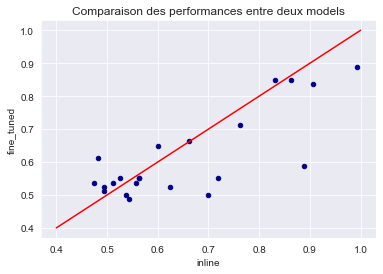

In [35]:
inline_accuracy = [84.375,55.625,98.125,51.25,51.25,65.625,47.5,56.225,66.25,82.5,51.875,60,65,49.375,75.625,49.375,45.625,82.5,98.125,83.125,56.875,88.75,51.875,93.125,81.25,65.625,45.625,48.125,52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875, 51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875, 99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625, 47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25, 80.625, 62.5 ,73.125]

inline_order = ["A1"  ,"A2" ,"A3" ,"A4" ,"A5" ,"A6" ,"A7" ,"A8" ,"A9" ,"A10" ,"A11" ,"A12" ,"A13" ,"A14" ,"A15" ,"A16" ,"A17" ,"A18" ,"A19" ,"A20" ,"A21" ,"A22" ,"A23" ,"A24" ,"A25" ,"A26" ,"A27" ,"A28" ,"A29" ,"A30" ,"A31" ,"A32" ,"A33" ,"A34" ,"A35" ,"A36" ,"A37" ,"A38" ,"A39" ,"A40" ,"A41" ,"A42" ,"A43" ,"A44" ,"A45" ,"A46" ,"A47" ,"A48" ,"A49" ,"A50" ,"A51" ,"A52" ,"A53" ,"A54" ,"A55" ,"A56" ,"A57" ,"A58" ,"A59" ,"A60" ,"B61" ,"B62" ,"B63" ,"B64" ,"B65" ,"B66" ,"B67" ,"B68" ,"B69" ,"B70" ,"B71" ,"B72" ,"B73" ,"B74" ,"B75" ,"B76" ,"B77" ,"B78" ,"B79" ,"B80" ,"B81" ,"C82" ,"C83" ,"C84" ,"C85" ,"C86" ,"C87"]




inline_results = pd.DataFrame(inline_accuracy, inline_order, columns= ["inline"])
inline_results = inline_results/100

accuracy["inline"] = inline_results["inline"][accuracy.index]

ax1 = accuracy.plot.scatter(x='inline',y='fine_tuned', c='DarkBlue')
ax1.plot([0.4,1],[0.4,1], c="red")
ax1.set_title("Comparaison des performances entre deux models")

In [231]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 27, 1024, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 27, 1024, 8)       512       
                                                                 
 batch_normalization_9 (Batc  (None, 27, 1024, 8)      32        
 hNormalization)                                                 
                                                                 
 depthwise_conv2d_3 (Depthwi  (None, 1, 1024, 16)      432       
 seConv2D)                                                       
                                                                 
 batch_normalization_10 (Bat  (None, 1, 1024, 16)      64        
 chNormalization)                                                
                                                           

In [234]:

flatten      = Flatten(name = 'flatten')(block2)

dense        = Dense(nb_classes, name = 'dense',
                     kernel_constraint = max_norm(norm_rate))(flatten)
softmax      = Activation('softmax', name = 'softmax')(dense)

AttributeError: 'list' object has no attribute 'trainable'

In [341]:
model = load_model(directory_model)
print(model.layers[-2].get_weights()[0][0])




print(model.layers[-2].get_weights()[0][0])


[ 0.01889907 -0.0188991 ]
[0.05963019 0.09490354]


In [327]:
model.evaluate(x = X_valid_train, y = Y_valid_train)

3/3 [==============================] - 0s 22ms/step - loss: 0.6624 - binary_accuracy: 0.5750


[0.6624225378036499, 0.574999988079071]

In [337]:
model.layers[-2].get_weights()[0]


array([[ 0.01889907, -0.0188991 ],
       [-0.00867759,  0.00867755],
       [-0.01202742,  0.01202741],
       ...,
       [ 0.00725783, -0.00725794],
       [ 0.01566049, -0.01566039],
       [ 0.00198506, -0.00198509]], dtype=float32)

In [ ]:

if hasattr(layer, 'kernel_initializer'):
    layer.kernel.initializer.run(session=session)
if hasattr(layer, 'bias_initializer'):
    layer.bias.initializer.run(session=session)

In [223]:
winsound.Beep(440, 500)
winsound.Beep(330, 400)
winsound.Beep(550, 500)

In [410]:
inline_accuracy = [84.375, 55.625, 98.125, 51.25, 51.25, 65.625, 47.5, 56.225, 66.25, 82.5, 51.875, 60, 65, 49.375,
                   75.625, 49.375, 45.625, 82.5, 98.125, 83.125, 56.875, 88.75, 51.875, 93.125, 81.25, 65.625, 45.625,
                   48.125, 52.5, 40.625, 52.5, 55.5, 62.5, 48.125, 90.625, 70, 47.5, 62.5, 81.25, 49.0625, 51.875,
                   51.875, 55, 56.25, 54.375, 54.375, 46.25, 56.625, 55, 52.5, 64.375, 88.75, 46.25, 47.5, 91.875,
                   99.375, 48.75, 66.25, 60, 56.25, 84.375, 90.625, 60, 50, 82.5, 58.75, 51.875, 55, 60.625, 55.625,
                   47.5, 44.375, 86.25, 68.125, 71.875, 80.625, 53.75, 55, 97.5, 49.375, 55, 49.375, 44.375, 76.25,
                   80.625, 62.5, 73.125]

inline_order = ["A1", "A2", "A3", "A4", "A5", "A6", "A7", "A8", "A9", "A10", "A11", "A12", "A13", "A14", "A15", "A16",
                "A17", "A18", "A19", "A20", "A21", "A22", "A23", "A24", "A25", "A26", "A27", "A28", "A29", "A30", "A31",
                "A32", "A33", "A34", "A35", "A36", "A37", "A38", "A39", "A40", "A41", "A42", "A43", "A44", "A45", "A46",
                "A47", "A48", "A49", "A50", "A51", "A52", "A53", "A54", "A55", "A56", "A57", "A58", "A59", "A60", "B61",
                "B62", "B63", "B64", "B65", "B66", "B67", "B68", "B69", "B70", "B71", "B72", "B73", "B74", "B75", "B76",
                "B77", "B78", "B79", "B80", "B81", "C82", "C83", "C84", "C85", "C86", "C87"]

inline_age = [1993, 1993, 1969, 1982, 1985, 1970, 1997, 1992, 1996, 1997, 1997, 1993, 1997, 1994, 1988, 1996, 1997,
              1995, 1985, 1996, 1988, 1989, 1994, 1985, 1999, 1998, 1981, 1995, 1997, 1996, 1978, 1969, 1992, 1993,
              1993, 1990, 1959, 1973, 1996, 1999, 1989, 1994, 1980, 1988, 1977, 1993, 1990, 1997, 1981, 1997, 1975,
              1997, 1991, 1989, 1996, 1998, 1996, 1996, 1991, 1968, 1992, 2002, 2000, 1985, 1998, 1979, 1978, 1999,
              1984, 1998, 1997, 1993, 1969, 1996, 1998, 1998, 1978, 1999, 1994, 1995, 1997, 1995, 1997, 2001, 1991,
              2000, 2000]
data = pd.DataFrame({"accuracy": inline_accuracy, "age": inline_age}, index=[inline_order])
data["age"] = 2021 - data["age"]
data =data.drop(["A40"], axis=0)

C:\Users\dtrocell\AppData\Local\Temp\ipykernel_10440\1641972643.py:24: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data =data.drop(["A40"], axis=0)


In [421]:


age_cat = [(19,23), (23, 24), (24, 27), (27,30), (30,40), (40, 61)]

dict_age =  {}
for age_min, age_max in age_cat :

    dict_age[(age_min,age_max)] = list(data[np.logical_and(data["age"] > age_min , data["age"] <= age_max)].index)


In [422]:
for val in dict_age.values():
    print(len(val))

13
12
17
13
16
13


# Shalllow FBCSP net